# vine copula (vinecop)

- Fitting

> obs -> edge -> tree -> bcp -> (next lv) obs

The function `VineCop.fit` takes multivariate copula observations (of shape $(n,D)$ and values inside $(0,1)$). By default at each level, it proposes potential edges between (pseudo)observations under proximity conditions, calculates corresponding bivariate dependency metrics to determine bicops-to-fit using modified Kruskal's maximum spanning tree (MST, Dissmann 2013), then fit bicops and calculates pseudo-obs for the next level using their `hfunc`.

This function can make `VineCop` following c/d/r-vine restrictions using Dissmann algo, and can use existing structure matrix to make `VineCop`.

This function can prioritize vertices inside `first_tree_vertex` such that the fitted vine can be used to conduct **conditional simulation**.

- Simulation (inverse Rosenblatt transform)

The `sample_order` attribute inside a `VineCop` object shows sequentially (from right to left, from shallowest to deepest) `D` pseudo-observation (on `D` levels) as source vertices to walk `D` paths until their corresponding `D` target vertices on the top level. Along each path, iteratively we do `hinv` from lower vertex to upper vertex, but may (recursively) request `hfunc` if its opposite upper vertex is not available.

With `first_tree_vertex` given during fitting, the fitted `VineCop` object allows for **conditional simulation**, where `dct_v_s_obs` and `sample_order` can be specified for `.sample()`.


In [1]:
import sys
import platform
import math
import torch
from torch.special import ndtr
import torchvinecopulib as tvc
from torchvinecopulib.util import _EPS

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "cpu"
print("Python:", sys.version.replace("\n", " "))
print("Platform:", platform.platform())
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

rho = 0.95
V = torch.randn(size=(10000, 2), dtype=torch.float64)
V[:, 1] = rho * V[:, 0] + math.sqrt(1 - rho**2) * V[:, 1]
VV = torch.randn(size=(5000, 2), dtype=torch.float64)
VV[:, 1] = -rho * VV[:, 0] + math.sqrt(1 - rho**2) * VV[:, 1]
V = ndtr(torch.vstack([V, VV])).clamp(_EPS, 1 - _EPS)
obs_mvcp = V
for _ in range(2):
    obs_mvcp = torch.hstack(
        [
            obs_mvcp,
            torch.hstack(
                [
                    obs_mvcp[torch.randperm(obs_mvcp.shape[0]), [0]].reshape(-1, 1),
                    obs_mvcp[torch.randperm(obs_mvcp.shape[0]), [1]].reshape(-1, 1),
                ]
            ),
        ]
    )
obs_mvcp = obs_mvcp[:1000, :7].to(DEVICE)

Python: 3.13.3 (main, Apr  8 2025, 13:54:08) [Clang 16.0.0 (clang-1600.0.26.6)]
Platform: macOS-15.4.1-arm64-arm-64bit-Mach-O
PyTorch: 2.7.0
CUDA available: False


In [2]:
num_step_grid = 128
mdl_vcp = tvc.vinecop.VineCop(
    num_dim=obs_mvcp.shape[1],
    # ! num_step_grid has to be a power of 2 !
    num_step_grid=num_step_grid,
    device=DEVICE,
)
mdl_vcp.fit(obs_mvcp=obs_mvcp, mtd_vine="rvine", first_tree_vertex=(0, 5))
print(mdl_vcp)

VineCop
'num_dim': 6,
 'num_obs': 1_000,
 'mtd_bidep': 'chatterjee_xi',
 'negloglik': -671.996,
 'num_step_grid': 128,
 'dtype': torch.float64,
 'device': 'cpu',
 'sample_order': (3, 4, 2, 1, 0, 5),
 'matrix':
    tensor([[ 3,  4,  2,  1,  0,  5],
            [-1,  4,  5,  0,  1,  2],
            [-1, -1,  2,  5,  0,  1],
            [-1, -1, -1,  1,  5,  0],
            [-1, -1, -1, -1,  0,  5],
            [-1, -1, -1, -1, -1,  5]], dtype=torch.int32)




(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine level 1'}>,
 <networkx.classes.graph.Graph at 0x1771a9fd0>)

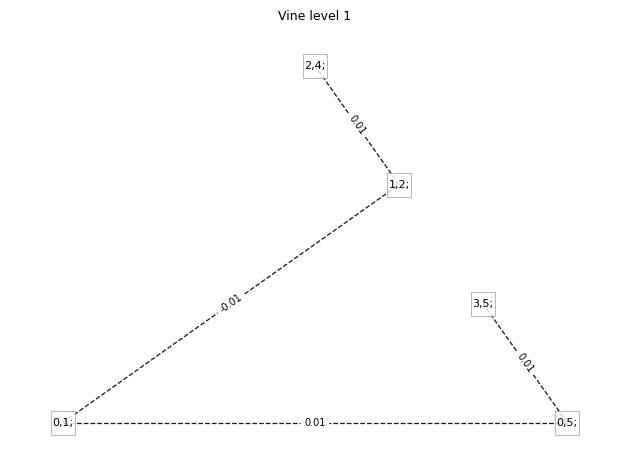

In [3]:
mdl_vcp.draw_lv(lv=1, is_bcp=True)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine comp graph'}>,
 <networkx.classes.digraph.DiGraph at 0x177956210>)

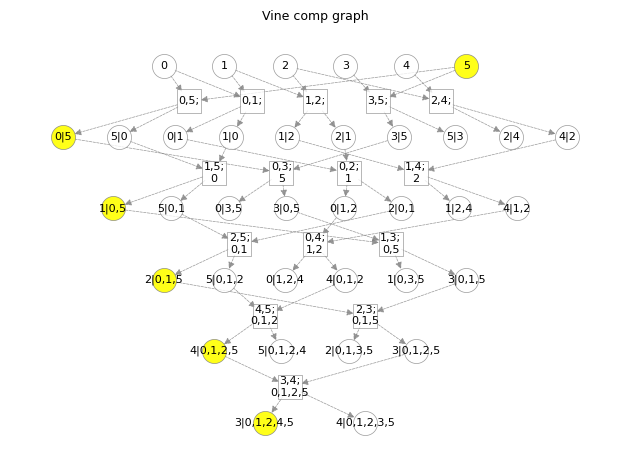

In [4]:
mdl_vcp.draw_dag()

## inside a VineCop obj

- $\frac{D(D-1)}{2}$ bicops (`torch.nn.Module` inside `ModuleDict`)
- parents of bicops
- parents of pseudo-obs
- a `staticmethod` oracle to query the number of h-function calls (and source vertices) given a sampling order on a vine


<Axes: title={'center': 'Estimated bivariate copula density'}, xlabel='$u_1$', ylabel='$u_2$'>

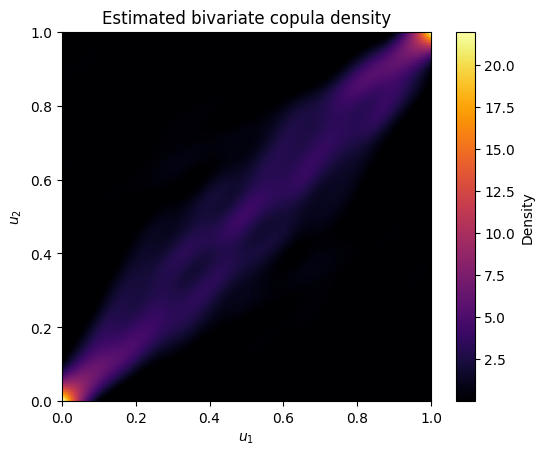

In [5]:
next(iter(mdl_vcp.bicops.values())).imshow()

In [6]:
print(mdl_vcp.bicops, mdl_vcp.struct_bcp, mdl_vcp.struct_obs)
mdl_vcp.ref_count_hfunc(
    num_dim=mdl_vcp.num_dim,
    struct_obs=mdl_vcp.struct_obs,
    sample_order=mdl_vcp.sample_order,
)

ModuleDict(
  (0,1): BiCop()
  (0,2): BiCop()
  (0,3): BiCop()
  (0,4): BiCop()
  (0,5): BiCop()
  (1,2): BiCop()
  (1,3): BiCop()
  (1,4): BiCop()
  (1,5): BiCop()
  (2,3): BiCop()
  (2,4): BiCop()
  (2,5): BiCop()
  (3,4): BiCop()
  (3,5): BiCop()
  (4,5): BiCop()
) {'0,1': {'cond_ed': (0, 1), 'cond_ing': (), 'is_indep': False, 'left': '', 'right': ''}, '0,2': {'cond_ed': (0, 2), 'cond_ing': (1,), 'is_indep': False, 'left': '0,1', 'right': '1,2'}, '0,3': {'cond_ed': (0, 3), 'cond_ing': (5,), 'is_indep': False, 'left': '0,5', 'right': '3,5'}, '0,4': {'cond_ed': (0, 4), 'cond_ing': (1, 2), 'is_indep': False, 'left': '0,2', 'right': '1,4'}, '0,5': {'cond_ed': (0, 5), 'cond_ing': (), 'is_indep': False, 'left': '', 'right': ''}, '1,2': {'cond_ed': (1, 2), 'cond_ing': (), 'is_indep': False, 'left': '', 'right': ''}, '1,3': {'cond_ed': (1, 3), 'cond_ing': (0, 5), 'is_indep': False, 'left': '1,5', 'right': '0,3'}, '1,4': {'cond_ed': (1, 4), 'cond_ing': (2,), 'is_indep': False, 'left': '1,2',

({(5,): 4,
  (0,): 4,
  (0, 5): 2,
  (5, 0): 3,
  (1, 0): 3,
  (1, 0, 5): 2,
  (1,): 4,
  (5, 0, 1): 3,
  (2, 0, 1): 3,
  (2, 0, 1, 5): 2,
  (0, 1): 3,
  (2, 1): 3,
  (2,): 3,
  (5, 0, 1, 2): 2,
  (4, 0, 1, 2): 2,
  (4, 0, 1, 2, 5): 2,
  (0, 1, 2): 2,
  (4, 1, 2): 2,
  (1, 2): 2,
  (4, 2): 2,
  (4,): 1,
  (3, 0, 1, 2, 5): 2,
  (3, 0, 1, 2, 4, 5): 1,
  (3, 0, 1, 5): 2,
  (3, 0, 5): 2,
  (3, 5): 2,
  (3,): 1},
 [(5,), (0, 5), (1, 0, 5), (2, 0, 1, 5), (4, 0, 1, 2, 5), (3, 0, 1, 2, 4, 5)],
 7)

## log_pdf, cdf


In [7]:
mdl_vcp.log_pdf(obs_mvcp=obs_mvcp)

tensor([[ 1.1656e+00],
        [ 7.1102e-01],
        [ 7.7393e-01],
        [ 8.2305e-01],
        [-1.2170e+00],
        [ 9.6087e-01],
        [ 6.4273e-01],
        [ 7.1017e-01],
        [ 3.7185e-01],
        [ 9.8694e-01],
        [ 1.2077e+00],
        [ 6.5453e-01],
        [ 9.1313e-01],
        [ 8.9781e-01],
        [ 8.4196e-01],
        [ 1.1240e+00],
        [ 5.8169e-01],
        [ 2.0222e+00],
        [ 1.4850e+00],
        [-4.3845e-01],
        [-5.6268e-03],
        [ 8.6714e-01],
        [ 6.9161e-01],
        [ 1.0954e+00],
        [-6.0923e-01],
        [ 6.8422e-01],
        [ 8.6581e-01],
        [ 5.3756e-01],
        [ 9.5909e-01],
        [ 1.0428e+00],
        [ 1.0861e+00],
        [ 2.0107e-01],
        [-5.1444e-01],
        [ 1.5412e+00],
        [ 1.6502e+00],
        [ 6.5917e-01],
        [ 2.1710e+00],
        [ 9.8725e-01],
        [ 1.1316e+00],
        [-3.0947e-01],
        [ 1.0485e+00],
        [ 1.6531e+00],
        [ 1.1773e+00],
        [ 1

In [12]:
mdl_vcp.cdf(obs_mvcp=obs_mvcp)

tensor([[1.1014e-01],
        [1.2780e-02],
        [2.8620e-02],
        [3.8300e-02],
        [3.9980e-02],
        [9.3820e-02],
        [4.9360e-02],
        [7.0840e-02],
        [5.9400e-03],
        [5.2200e-03],
        [2.4880e-02],
        [1.3760e-02],
        [1.9720e-02],
        [2.1268e-01],
        [9.8000e-03],
        [1.0614e-01],
        [1.2080e-02],
        [4.2000e-04],
        [6.3060e-02],
        [1.0100e-02],
        [2.1700e-02],
        [1.6480e-02],
        [7.2200e-03],
        [1.1200e-03],
        [1.9020e-02],
        [5.8100e-02],
        [4.0400e-03],
        [8.8260e-02],
        [6.9000e-03],
        [1.4800e-02],
        [7.2200e-03],
        [1.7020e-02],
        [1.5800e-03],
        [2.3880e-02],
        [2.9760e-02],
        [5.7880e-02],
        [9.4480e-02],
        [9.8800e-03],
        [2.8000e-04],
        [8.8200e-03],
        [8.6000e-04],
        [1.2200e-03],
        [1.7200e-03],
        [1.8246e-01],
        [5.4480e-02],
        [1

# (conditional) sampling

- default sampling given $0$ columns of observations
- quantile regression given $D-1$ columns of observations
- conditional simulation otherwise


In [13]:
mdl_vcp.sample()

tensor([[0.0645, 0.0127, 0.0331, 0.4601, 0.4083, 0.0582],
        [0.9292, 0.8274, 0.1356, 0.3873, 0.1177, 0.9552],
        [0.8696, 0.8258, 0.6331, 0.7111, 0.0765, 0.8425],
        ...,
        [0.3019, 1.0000, 0.7178, 0.2841, 0.9650, 0.8312],
        [0.7974, 0.6896, 0.0316, 0.9195, 0.1316, 0.8598],
        [0.7135, 0.7248, 0.0050, 0.9733, 0.8686, 0.8926]], dtype=torch.float64)

In [10]:
mdl_vcp.sample_order

(3, 4, 2, 1, 0, 5)

In [11]:
mdl_vcp.sample(
    num_sample=1000,
    is_sobol=True,
    sample_order=mdl_vcp.sample_order[:-2],
    dct_v_s_obs={
        (mdl_vcp.sample_order[-1],): torch.ones(size=(1000, 1), device=obs_mvcp.device),
        (mdl_vcp.sample_order[-2],): torch.zeros(
            size=(1000, 1), device=obs_mvcp.device
        ),
    },
)

tensor([[1.0000e-07, 1.0000e+00, 8.9224e-02, 4.5524e-01, 8.4485e-01, 1.0000e+00],
        [1.0000e-07, 1.6684e-02, 8.4158e-01, 6.5043e-01, 6.4054e-02, 1.0000e+00],
        [1.0000e-07, 2.9493e-03, 3.2990e-01, 1.5405e-01, 7.1758e-01, 1.0000e+00],
        ...,
        [1.0000e-07, 5.0000e-08, 9.0836e-01, 7.3446e-01, 6.9561e-01, 1.0000e+00],
        [1.0000e-07, 9.4557e-03, 4.0417e-01, 5.0000e-08, 5.0000e-08, 1.0000e+00],
        [1.0000e-07, 5.3435e-02, 6.4483e-01, 1.0000e+00, 8.0627e-01, 1.0000e+00]],
       dtype=torch.float64)